In [1]:
# importing modules I will use
import pandas as pd
import json
from collections import defaultdict, Counter
import ast
import matplotlib.pyplot as plt
import requests
import json
from flask import Flask, request
from jinja2 import Environment
from urllib.request import Request, urlopen
import os
import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import pickle
import numpy as np
# API key I use to download the movie posters from TMDB
api_key = '39329068bc1de1536d231b6b49c9ff50'
import numpy as np
import ast
import re
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import KeyedVectors
import string
from nltk.tokenize import RegexpTokenizer
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchtext.data import Field, BucketIterator, Iterator, TabularDataset
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
device = torch.device('cuda:2') #if torch.cuda.is_available() else 'cpu')


Using TensorFlow backend.


## Mostly Preprocessing

In [86]:
# loading the dataset.

df=pd.read_csv('movies_metadata.csv')

/home/gusmavko@GU.GU.SE/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
# other features to use
df.columns


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [81]:
# we want to only keep the columns that are relevant for our task and drop the rest.

df = df[['original_title','overview','id','genres','original_language','production_companies']]
df_copy = df.copy()
df_copy.head()

,original_title,overview,id,genres,original_language,production_companies
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]"
1,Jumanji,When siblings Judy and Peter discover an encha...,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,11862,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}..."


In [58]:
# list of genres that do not really make sense and appear only once so I decided to remove them.

weird_genres = ['TV Movie', 'Carousel Productions', 'Vision View Entertainment',
 'Telescene Film Group Productions', 'Aniplex', 'GoHands',
 'BROSTA TV', 'Mardock Scramble Production Committee', 'Sentai Filmworks',
 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'The Cartel']

In [59]:
# This function cleans up the column containing the movie genres, which has a really weird formatting.

def clean_genres(df):
    list_of_genres = []
    for i,row in df['genres'].iteritems():
        row = ast.literal_eval(row)
        row_list = []
        for dic in row:
            if dic['name'] not in weird_genres:
                row_list.append(dic['name'])
        list_of_genres.append(row_list)
    return list_of_genres
        
df['genres'] = clean_genres(df)


In [66]:
df.columns

Index(['original_title', 'overview', 'id', 'genres', 'poster_paths'], dtype='object')

In [61]:
# dropping occurrences that appear only once and NaNs

df = df[df['genres'].map(lambda d: len(d)) > 0].dropna()
df.shape

(42306, 6)

In [62]:
# removing all rows of non English movies

def isEnglish(s):
    return s.isascii()
def remove_noneng_titles(df):
    noneng = []
    for title in df['original_title'].tolist():
        if not isEnglish(title):
            noneng.append(title)
    df = df[~df['original_title'].isin(noneng)]
    return df
df = remove_noneng_titles(df)

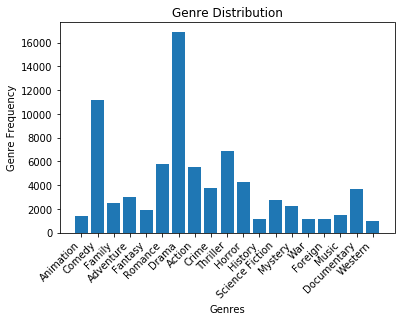

In [22]:
# This function plots the distribution of movie genres in the dataset. 

def plot_distribution(df):
    genres = df.genres.values
    flattened_genres = [item for sublist in genres for item in sublist]
    count_of_genres = Counter(flattened_genres)    
    fig, ax = plt.subplots()
    plt.bar(count_of_genres.keys(), count_of_genres.values())
    plt.title("Genre Distribution")
    plt.ylabel('Genre Frequency')
    plt.xlabel('Genres')
    # Rotate 45 degrees 
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.show()
    
plot_distribution(df)   

In [23]:
# This function uses the TMDB API to retrieve a url of every movie poster and then it downloads it locally.
def get_data(movie_id):
    # I use try - except to avoid my function crashing from potential errors (e.g. in the case that there is no poster in the json dictionary)
    try:
        url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}"
     
        request = Request(url)
        response = urlopen(request)
        data = response.read()
        poster_path = json.loads(data)['poster_path']        
        init_url = 'https://image.tmdb.org/t/p/w500'
        image_url = init_url + poster_path     
        r = requests.get(image_url)
        name = poster_path.replace('/', '_') 
        filename = f"poster{name}"
        pa = os.path.join('/home/gusmavko@GU.GU.SE/aics-project/data/images', filename)        
        # preferred for "binary" filetypes, like poster images
        with open(pa,'wb') as w:
            w.write(r.content)       
        return pa
    except Exception:
        return 'Error'

In [24]:
# This function iterates through the dataframe id column and downloads the posters for all movies that have an available poster url.
def add_poster(df): 
    poster_paths = []
    for movie_id in tqdm.tqdm(df['id'].tolist()):
        try:
            poster_paths.append(get_data(movie_id))
            print(movie_id)
        except Exception as e:
            print('[ERROR]', str(e))
            poster_paths.append("API Error")
    
    return poster_paths


In [ ]:
# This takes so long to run, I have downloaded them locally so I can perhaps just upload them on drive if somebody does not want to run this.

list_of_posters = add_poster(df)

In [27]:
# I also dropped all rows that did not have a poster or movies that caused an error. 
    
def finalize_df(df):
    # There is something wrong with this image, it can't be opened so I decided to just drop it.
    unidentifiable_image_file = '/home/gusmavko@GU.GU.SE/aics-project/data/images/poster_b15FrCKeWVH62Sn3o69ZXZi3bBi.jpg'
    df['poster_paths'] = list_of_posters  
    df = df[df.poster_paths != "API Error"]
    df = df[df.poster_paths != "Error"]
    df = df[df.poster_paths != unidentifiable_image_file]
    return df
df = finalize_df(df)

NameError: name 'list_of_posters' is not defined

In [ ]:
# save to csv file to be able to load it easily later
df.to_csv("/home/gusmavko@GU.GU.SE/aics-project/data/dataset.csv",index=False)

In [87]:
#df = pd.read_csv("/home/gusmavko@GU.GU.SE/aics-project/data/dataset.csv")

#df = remove_noneng_titles(df)
np.random.seed(10)
#
remove_n = 17000
#df = pd.DataFrame({"a":[1,2,3,4], "b":[5,6,7,8]})
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)
#df_subset.shape[0]
df.shape
df.to_csv('"/home/gusmavko@GU.GU.SE/aics-project/data/half_data.csv",index=False')

(28466, 24)

In [88]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state = 42)



In [89]:
#val.to_csv("/home/gusmavko@GU.GU.SE/aics-project/data/val_half.csv",index=False)
#test.to_csv("/home/gusmavko@GU.GU.SE/aics-project/data/test_half.csv",index=False)
#train.to_csv("/home/gusmavko@GU.GU.SE/aics-project/data/train_half.csv",index=False)

val_df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/val_half.csv')
test_df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/test_half.csv')
train_df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/train_half.csv')

train_df.shape

(12567, 5)

In [90]:
# This function makes a tensor out of an image array and saves it to the gpu.
def create_img_tensor(img_path, dimensions):
    try:
        img=Image.open(img_path)
        res_img = img.resize(dimensions).convert('RGB')
        img_array = np.array(res_img)
        img_tensor = torch.tensor(img_array)#.to(device) # commented it out the saving to the gpu server because it caused a lot of memory errors when experimenting with the model
    
        return img_tensor
    except Exception as e:
        print(str(e))
        return None


In [91]:
# This function iterates through the dataframe and creates tensor representations of all images
def get_tensors(df,dimensions): # dimensions should be a tuple containing (width, height) e.g. (100,100)
    
    list_imgs = [] 
    for i, row in df.iterrows():
        img = create_img_tensor(row['poster_paths'], dimensions)
        if img is not None:
            list_imgs.append(img)
        else:
            df = df.drop(i)            
    df_tensors = torch.stack(list_imgs)
    return df_tensors#.to(device)
    

In [92]:
# get tensor of tensors for validation set
val_tensors = get_tensors(val_df,(100,100))

In [93]:
#with open('/home/gusmavko@GU.GU.SE/aics-project/data/val_tensors','wb') as f: pickle.dump(val_tensors, f)

torch.save(val_tensors, '/home/gusmavko@GU.GU.SE/aics-project/data/val_half_tensors.pt')

In [94]:
# get tensor of tensors for test set
test_tensors = get_tensors(test_df,(100,100))

In [95]:
#with open('/home/gusmavko@GU.GU.SE/aics-project/data/test_tensors','wb') as f: pickle.dump(test_tensors, f)
torch.save(test_tensors,'/home/gusmavko@GU.GU.SE/aics-project/data/test_half_tensors.pt')

In [96]:
# get tensor of tensors for train set
train_tensors = get_tensors(train_df,(100,100))


In [97]:
#with open('/home/gusmavko@GU.GU.SE/aics-project/data/train_tensors','wb') as f: pickle.dump(train_tensors, f)
torch.save(train_tensors,'/home/gusmavko@GU.GU.SE/aics-project/data/train_half_tensors.pt')

In [98]:
train_tensors.shape

torch.Size([12567, 100, 100, 3])

## MODEL

In [9]:
# I have the tensors saved locally, I can upload them on my repo too
# I usually start things from this point

val_tensors = torch.load('/home/gusmavko@GU.GU.SE/aics-project/data/val_half_tensors.pt')
test_tensors = torch.load('/home/gusmavko@GU.GU.SE/aics-project/data/test_half_tensors.pt')
train_tensors = torch.load('/home/gusmavko@GU.GU.SE/aics-project/data/train_half_tensors.pt')

In [10]:
df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/dataset.csv')

train_df = pd.read_csv("/home/gusmavko@GU.GU.SE/aics-project/data/train_dataset.csv")
test_df = pd.read_csv("/home/gusmavko@GU.GU.SE/aics-project/data/test_dataset.csv")
val_df = pd.read_csv("/home/gusmavko@GU.GU.SE/aics-project/data/val_dataset.csv")

df['genres']=df['genres'].apply(lambda x: ast.literal_eval(x))

train_df['genres']=train_df['genres'].apply(lambda x: ast.literal_eval(x))
test_df['genres']=test_df['genres'].apply(lambda x: ast.literal_eval(x))
val_df['genres']=val_df['genres'].apply(lambda x: ast.literal_eval(x))



In [11]:
mlb = MultiLabelBinarizer()
# We need to pass a list of lists of the labels to get a one-hot encoding for the train, the test and the validation dataset.

# Fitting the multilabel binarizer to the labels available.
#mlb.fit(df['genres'].tolist())

train_labels = mlb.fit_transform(train_df['genres'].tolist())
test_labels = mlb.fit_transform(test_df['genres'].tolist())
val_labels = mlb.fit_transform(val_df['genres'].tolist())


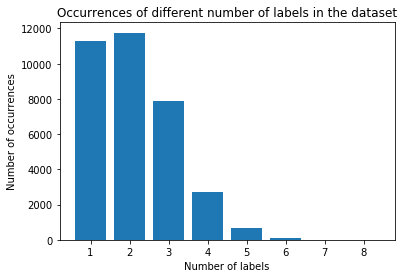

In [6]:
# This function creates a dictionary that has the number of movie labels as a key 
# and the number of occurrences of this number of labels as a value.

def plot_num_labels_movies(genre_lists):
    dic = {}
    for genre_list in genre_lists:
        if len(genre_list) in dic:
            dic[len(genre_list)] += 1
            
        else:
            dic[len(genre_list)] = 1
    return dic 

plot_dic = plot_num_labels_movies(df.genres.tolist())
plt.bar(*zip(*plot_dic.items()))
plt.title('Occurrences of different number of labels in the dataset')
plt.xlabel('Number of labels')
plt.ylabel('Number of occurrences')
plt.show()


In [12]:
swords = stopwords.words('english')
reg_ex_tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
#stemmer = Porter

# Thought about using different cleaning up methods for titles and summary.
def clean(text,is_for_summary=True):
    # removing punctuation and digits
    text = ''.join([c for c in text if c not in string.punctuation and not c.isdigit()])
    # tokenizing with the RegexpTokenizer and lowercasing the text
    text = reg_ex_tokenizer.tokenize(text.lower())
    # removing stop words if cleaning is applied on the overview - if we clean up the titles we keep the stop words since certain titles contain solely stop words(e.g. 'Who am I?').
    # maybe I should filter out stop words in titles too and only keep them when there are no other words.
    if is_for_summary:        
        text = [w for w in text if w not in swords]
    # lemmatizing the words with the WordNetLemmatizer and using join to put them back into a string
    text = ' '.join([lemmatizer.lemmatize(w) for w in text])
    return text

In [13]:
# creating new column consisting of both the title and the overview, which I will use when I want to 
#train a model with title, overview and image input.
train_df['title_and_overview'] = train_df['original_title'] + ' ' + train_df['overview']
test_df['title_and_overview'] = test_df['original_title'] + ' ' + test_df['overview']
val_df['title_and_overview'] = val_df['original_title'] + ' ' + val_df['overview']



In [14]:
# Cleaning up the orignal dataframe's overview and original_title column.
df['overview'] = df['overview'].apply(lambda x: clean(x))
df['original_title'] = df['original_title'].apply(lambda x: clean(x))

# Cleaning up the overview column.
train_df['overview'] = train_df['overview'].apply(lambda x: clean(x))
test_df['overview'] = test_df['overview'].apply(lambda x: clean(x))
val_df['overview'] = val_df['overview'].apply(lambda x: clean(x))

# Cleaning up the original title column.
train_df['original_title'] = train_df['original_title'].apply(lambda x: clean(x,False))
test_df['original_title'] = test_df['original_title'].apply(lambda x: clean(x,False))
val_df['original_title'] = val_df['original_title'].apply(lambda x: clean(x,False))


In [49]:
# creating new column consisting of both the title and the overview, which I will use when I want to 
#train a model with title, overview and image input.
train_df['title_and_overview'] = train_df['original_title'] + ' ' + train_df['overview']
test_df['title_and_overview'] = test_df['original_title'] + ' ' + test_df['overview']
val_df['title_and_overview'] = val_df['original_title'] + ' ' + val_df['overview']
df['title_and_overview'] = df['original_title'] + ' ' + df['overview']

train_df['title_and_overview'][0]

'boy michael jackson king even waihau bay new zealand meet boy yearold life farm gran goat younger brother rocky think magic power shortly gran leaf week boy father alamein appears blue imagined heroic version father absence boy come face face real versionan incompetent hoodlum returned find bag money buried year goat enters'

In [60]:



def trim_string(x):
    x = x.split()
    x = x[:400]
    x = ' '.join(x)
    return x
# Cleaning up the original title column.


In [61]:
train_df['title_and_overview'] = train_df['title_and_overview'].apply(trim_string)
test_df['title_and_overview'] = test_df['title_and_overview'].apply(trim_string)
val_df['title_and_overview'] = val_df['title_and_overview'].apply(trim_string)




In [ ]:
# Cleaned-up original_title and overview datadrame version is saved to csv files.

#train_df.to_csv('/home/gusmavko@GU.GU.SE/aics-project/data/train_ds.csv',index=False)
#test_df.to_csv('/home/gusmavko@GU.GU.SE/aics-project/data/test_ds.csv',index=False)
#val_df.to_csv('/home/gusmavko@GU.GU.SE/aics-project/data/val_ds.csv',index=False)  
#df.to_csv('/home/gusmavko@GU.GU.SE/aics-project/data/df_ds.csv',index=False)
                

In [ ]:
# Reloading the cleaned up csv files as dataframes.
train_df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/train_ds.csv')
test_df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/test_ds.csv')
val_df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/val_ds.csv')
df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/df_ds.csv')

In [62]:
# Merging the two columns containing textual data into one to cover all possible occurrences for words.
df_tit_overview = df[['original_title','overview']] 
df_vocab=df_tit_overview.stack().reset_index()
# Getting length of sequences for padding
max_len_for_padding = df_vocab[0].map(len).max()
max_len_title_overview = df['title_and_overview'].map(len).max()
embedding_dim = 300
tokenizer = Tokenizer(num_words=50000, lower=True)
tokenizer.fit_on_texts(df_vocab[0].values)
# Creating a word to integer dictionary for my vocab.
word_index = tokenizer.word_index


In [63]:
def embed_vocab(pretrained_dict, vocab, emb_size):
    # creating a dictionary with keys the words and values the pretrained word vectors. 
    embeddings_index = {}
    for w in pretrained_dict.wv.vocab:
        embeddings_index[w] = pretrained_dict.word_vec(w)     
    # instantiating matrix with shape (vocab + 1, 300)
    embedding_matrix = 1 * np.random.randn(len(vocab)+1, emb_size)
    # looking up the words in my vocab
    for word, i in vocab.items():
        i-=1
        # getting the pretrained vector for the corresponding word
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # adding the vector to the matrix
            embedding_matrix[i] = embedding_vector                      
    del(embeddings_index)
        
    return embedding_matrix

# need to download the pretrained vectors file

w2v_dic = KeyedVectors.load_word2vec_format("/home/gusmavko@GU.GU.SE/aics-project/data/GoogleNews-vectors-negative300.bin", binary=True)
word2vec_matrix = embed_vocab(w2v_dic, word_index, 300)

    

/home/gusmavko@GU.GU.SE/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [18]:
# Transforming each word token from the textual data into the corresponding index. 
# TODO maybe when padding do I need to pad the titles to the same length as the overview 

X_text_train = tokenizer.texts_to_sequences(train_df['overview'].values)
X_text_train = pad_sequences(X_text_train, maxlen=max_len_for_padding)

X_text_test = tokenizer.texts_to_sequences(test_df['overview'].values)
X_text_test = pad_sequences(X_text_test, maxlen=max_len_for_padding)

X_text_val = tokenizer.texts_to_sequences(val_df['overview'].values)
X_text_val = pad_sequences(X_text_val, maxlen=max_len_for_padding)

print(f'Train overview shape:{X_text_train.shape}, Test overview shape:{X_text_test.shape}, Validation overview shape:{X_text_val.shape}')

Train overview shape:(24807, 829), Test overview shape:(6892, 829), Validation overview shape:(2757, 829)


In [19]:
# Tranforming the titles to integer representations.

max_len_title = df['original_title'].map(len).max()

# train title

X_title_train = tokenizer.texts_to_sequences(train_df['original_title'].values)
X_title_train = pad_sequences(X_title_train,maxlen=max_len_title)
# test title

X_title_test = tokenizer.texts_to_sequences(test_df['original_title'].values)
X_title_test = pad_sequences(X_title_test,maxlen=max_len_title)

# val title
X_title_val = tokenizer.texts_to_sequences(val_df['original_title'].values)
X_title_val = pad_sequences(X_title_val,maxlen=max_len_title)

print(f'Train title shape:{X_title_train.shape}, Test overview shape:{X_title_test.shape}, Validation overview shape:{X_title_val.shape}')

Train title shape:(24807, 92), Test overview shape:(6892, 92), Validation overview shape:(2757, 92)


In [64]:
# Transforming the textual data containing the title and the overview into integer representations.
max_len_title_overview = 400

# train title_and_overview transformation
X_title_overview_train = tokenizer.texts_to_sequences(train_df['title_and_overview'].values)
X_title_overview_train = pad_sequences(X_title_overview_train,maxlen=max_len_title_overview)

# test title_and_overview transformation
X_title_overview_test = tokenizer.texts_to_sequences(test_df['title_and_overview'].values)
X_title_overview_test = pad_sequences(X_title_overview_test,maxlen=max_len_title_overview)

# val title_and_overview transformation
X_title_overview_val = tokenizer.texts_to_sequences(val_df['title_and_overview'].values)
X_title_overview_val = pad_sequences(X_title_overview_val,maxlen=max_len_title_overview)

print(f'Train title and overview combination shape:{X_title_overview_train.shape},Test title and overview combination shape:{X_title_overview_test.shape},Val title and overview combination shape:{X_title_overview_val.shape}')

Train title and overview combination shape:(24807, 400),Test title and overview combination shape:(6892, 400),Val title and overview combination shape:(2757, 400)


In [65]:
# Changing the dimensions of the tensors for when passing them in batches to the model.
X_img_val = val_tensors.permute(0,3,1,2)

X_img_test = test_tensors.permute(0,3,1,2)

X_img_train = train_tensors.permute(0,3,1,2)

In [22]:
# using TensorDataset to transform the arrays into tensors for my overview textual data
text_train_data = TensorDataset(torch.from_numpy(X_text_train), torch.from_numpy(train_labels))
img_train_data = TensorDataset(X_img_train, torch.from_numpy(train_labels))


text_val_data = TensorDataset(torch.from_numpy(X_text_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(X_img_val, torch.from_numpy(val_labels))
text_test_data = TensorDataset(torch.from_numpy(X_text_test), torch.from_numpy(test_labels))
img_test_data = TensorDataset(X_img_test, torch.from_numpy(test_labels))


In [23]:
batch_size = 5

text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)


## Overview and Image

In [43]:
# Building model for movie genre classification using textual and image features.

class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
        super(CNN_LSTM, self).__init__()

        # LSTM for the text overview
        self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
        num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.emb.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm_fc = nn.Linear(self.n_hidden, 128)
        
        # CNN for the posters
        self.conv1 = nn.Conv2d(3, 32, 3) # Gives me depth of input.
        # pooling layers to reduce the image size
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # pooling layers to reduce the image size
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        # pooling layers to reduce the image size
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, 3)
        # pooling layers to reduce the image size
        self.max_pool4 = nn.MaxPool2d(2)
        # to drop the nodes that are below the wanted weights
        self.cnn_dropout = nn.Dropout(0.1)
        self.cnn_fc = nn.Linear(4*4*128, 512) # Gives me number of features of input.
        
        # Concat layer for the combined feature space
        self.combined_fc1 = nn.Linear(640, 256) # Give me features of input.
        self.combined_fc2 = nn.Linear(256, 128)
        self.output_fc = nn.Linear(128, n_out)


    def forward(self, lstm_inp, cnn_inp):
        batch_size = lstm_inp.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_inp = lstm_inp.long()
        embeds = self.emb(lstm_inp)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.dropout(lstm_out[:, -1])
        lstm_out = F.relu(self.lstm_fc(lstm_out))

        x = F.relu(self.conv1(cnn_inp))
        x = self.max_pool1(x)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        #print(x.shape)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        #print(x.shape)
        x = F.relu(self.conv4(x))
        x = self.max_pool4(x)
        #print(x.shape) # that is how I get the correct dimensions for the CNN output that is then passed as input to the linear layer
        # need the input to be two dimensional again
        x = x.view(-1, 4*4*128)
        
        x = self.cnn_dropout(x)
        cnn_out = F.relu(self.cnn_fc(x))
        
        #concatenating the cnn output and the lstm output
        combined_inp = torch.cat((cnn_out, lstm_out), 1)
        # activation function
        x_comb = F.relu(self.combined_fc1(combined_inp))
        x_comb = F.relu(self.combined_fc2(x_comb))
        # sigmoid to get 1 and 0 on the one-hot-encoding formatted label
        out = torch.sigmoid(self.output_fc(x_comb))

        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [44]:
vocab_size = len(word_index)+1
output_size = train_labels.shape[1]
embedding_dim = 300
hidden_dim = 64
n_layers = 2

model = CNN_LSTM(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model.to(device)
print(model)

lr=0.001
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)


CNN_LSTM(
  (emb): Embedding(72673, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=2048, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_features=256, bia

In [45]:
epochs = 20 # try larger number of epochs
clip = 5

model.train()
for i in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    
    for lstm, cnn in zip(text_train_loader, img_train_loader):
        lstm_inp,lstm_labels = lstm
        lstm_inp = lstm_inp.float()
        cnn_inp, cnn_labels = cnn
        cnn_inp = cnn_inp.float()
        lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
        cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
        model.zero_grad()
        output = model(lstm_inp, cnn_inp)
        loss = criterion(output.squeeze(), lstm_labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
        with torch.no_grad():
            acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_train += acc
            total_loss_train += loss.item()
  
    train_acc = total_acc_train/len(text_train_loader)
    train_loss = total_loss_train/len(text_train_loader)
    print('done training',train_acc)
    model.eval()
    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():
        for lstm, cnn in zip(text_val_loader, img_val_loader):
            lstm_inp, lstm_labels = lstm
            lstm_inp = lstm_inp.float()
            cnn_inp, cnn_labels = cnn
            cnn_inp = cnn_inp.float()
            lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
            cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
            model.zero_grad()
            output = model(lstm_inp, cnn_inp)
            val_loss = criterion(output.squeeze(), lstm_labels.float())
            acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_val += acc
            total_loss_val += val_loss.item()
    print("Saving model...") 
    torch.save(model.state_dict(), '/home/gusmavko@GU.GU.SE/aics-project/data/model_title_img.pt')

    val_acc = total_acc_val/len(text_val_loader)
    val_loss = total_loss_val/len(text_val_loader)
    print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    model.train()
    torch.cuda.empty_cache()

done training tensor(0.8251, device='cuda:1')
Saving model...
Epoch 1: train_loss: 0.3006 train_acc: 0.8251 | val_loss: 0.2835 val_acc: 0.8230


RuntimeError: CUDA error: out of memory

## Attempt at using title, image, poster as input

In [27]:
# Attempting to add title when loading the dataset.
# Again, using TensorDataset to transform the arrays into tensors for my textual data.

## train dataset
#text_train_data = TensorDataset(torch.from_numpy(X_text_train), torch.from_numpy(X_title_train), torch.from_numpy(train_labels))
##img_train_data = TensorDataset(X_img_train, torch.from_numpy(train_labels))
#
## validation dataset
#text_val_data = TensorDataset(torch.from_numpy(X_text_val), torch.from_numpy(X_title_val), torch.from_numpy(val_labels))
##img_val_data = TensorDataset(X_img_val, torch.from_numpy(val_labels))
#
## test dataset
#text_test_data = TensorDataset(torch.from_numpy(X_text_test), torch.from_numpy(test_labels))
#img_test_data = TensorDataset(X_img_test, torch.from_numpy(test_labels))
#
#batch_size = 40
#
#text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
#img_train_loader = DataLoader(img_train_data, batch_size=batch_size)
#
#text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
#img_val_loader = DataLoader(img_val_data, batch_size=batch_size)
#
#text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
#img_test_loader = DataLoader(img_test_data, batch_size=batch_size)

# using TensorDataset to transform the arrays into tensors for my overview textual data



In [40]:
vocab_size = len(word_index)+1
output_size = train_labels.shape[1]
embedding_dim = 300
hidden_dim = 64
n_layers = 2

model = CNN_LSTM_3(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model.to(device)
print(model)

lr=0.001
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
print(device)

CNN_LSTM_3(
  (emb): Embedding(72673, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=2048, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_features=256, b

In [45]:
# Building model for movie genre classification using textual and image features.

class CNN_LSTM_3(nn.Module):
    def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
        super(CNN_LSTM_3, self).__init__()

        # LSTM for the text overview
        self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
        num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.emb.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm_fc = nn.Linear(self.n_hidden, 128)
        
        # CNN for the posters
        self.conv1 = nn.Conv2d(3, 32, 3) # Gives me depth of input.
        # pooling layers to reduce the image size
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # pooling layers to reduce the image size
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        # pooling layers to reduce the image size
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, 3)
        # pooling layers to reduce the image size
        self.max_pool4 = nn.MaxPool2d(2)
        # to drop the nodes that are below the wanted weights
        self.cnn_dropout = nn.Dropout(0.1)
        self.cnn_fc = nn.Linear(4*4*128, 512) # Gives me number of features of input.
        
        # Concat layer for the combined feature space
        self.combined_fc1 = nn.Linear(640, 256) # Give me features of input.
        self.combined_fc2 = nn.Linear(256, 128)
        self.output_fc = nn.Linear(128, n_out)


    def forward(self, lstm_in, cnn_inp, title_inp):
        batch_size = lstm_in.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_in = lstm_in.long()
        title_inp = title_inp.long()
        lstm_inp = torch.cat((lstm_in,title_inp),dim=1)
        embeds = self.emb(lstm_inp)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.dropout(lstm_out[:, -1])
        lstm_out = F.relu(self.lstm_fc(lstm_out))
        
        # title input
        #title_inp = title_inp.long()
        #embeds2 = self.emb(title_inp)
        #title_out, hidden = self.lstm(embeds2, hidden)
        #title_out = self.dropout(title_out[:,-1])
        #title_out = F.relu(self.lstm_fc(title_out))
        
        #combined_text_inp = torch.cat((title_out, lstm_out), 1)
        
        x = F.relu(self.conv1(cnn_inp))
        x = self.max_pool1(x)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        #print(x.shape)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        #print(x.shape)
        x = F.relu(self.conv4(x))
        x = self.max_pool4(x)
        #print(x.shape) # that is how I get the correct dimensions for the CNN output that is then passed as input to the linear layer
        # need the input to be two dimensional again
        x = x.view(-1, 4*4*128)
        
        x = self.cnn_dropout(x)
        cnn_out = F.relu(self.cnn_fc(x))
        
        #concatenating the cnn output and the lstm output
        combined_inp = torch.cat((cnn_out, lstm_out), 1)
        # activation function
        x_comb = F.relu(self.combined_fc1(combined_inp))
        x_comb = F.relu(self.combined_fc2(x_comb))
        # sigmoid to get 1 and 0 on the one-hot-encoding formatted label
        out = torch.sigmoid(self.output_fc(x_comb))

        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [46]:
device = torch.device('cpu')
vocab_size = len(word_index)+1
output_size = train_labels.shape[1]
embedding_dim = 300
hidden_dim = 64
n_layers = 2

model = CNN_LSTM_3(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model.to(device)
print(model)

lr=0.001
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)



CNN_LSTM_3(
  (emb): Embedding(72673, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=2048, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_features=256, b

In [ ]:
epochs = 20 # try larger number of epochs
clip = 5
#model = CNN_LSTM_3(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
#model.to(device)
model.train()
for i in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    
    for lstm, cnn in zip(text_train_loader, img_train_loader):
        lstm_inp, title_inp, lstm_labels = lstm
        
        title_inp = title_inp.float()
        lstm_inp = lstm_inp.float()
        #print(lstm_inp)
        cnn_inp, cnn_labels = cnn
        cnn_inp = cnn_inp.float()
        #title_inp,title_labels = title_inp.to(device),title_labels.to(device)
        lstm_inp, title_inp,lstm_labels = lstm_inp.to(device), title_inp.to(device), lstm_labels.to(device)
        cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
        model.zero_grad()
        output = model(lstm_inp, cnn_inp,title_inp)
        #print(output)
        loss = criterion(output.squeeze(), lstm_labels.float())
        print(loss)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
        with torch.no_grad():
            acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_train += acc
            total_loss_train += loss.item()
  
    train_acc = total_acc_train/len(text_train_loader)
    train_loss = total_loss_train/len(text_train_loader)
    print('done training',train_acc)
    model.eval()
    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():
        for lstm, cnn in zip(text_val_loader, img_val_loader):
            lstm_inp, title_inp, lstm_labels = lstm
            lstm_inp = lstm_inp.float()
            title_inp = title_inp.float()
            cnn_inp, cnn_labels = cnn
            cnn_inp = cnn_inp.float()
            lstm_inp, title_inp, lstm_labels = lstm_inp.to(device),title_inp.tο(device), lstm_labels.to(device)
            cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
            model.zero_grad()
            output = model(lstm_inp, cnn_inp,title_inp)
            val_loss = criterion(output.squeeze(), lstm_labels.float())
            acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_val += acc
            total_loss_val += val_loss.item()
    print("Saving model...") 
    torch.save(model.state_dict(), '/home/gusmavko@GU.GU.SE/aics-project/data/model_title_overview_img.pt')
#
    val_acc = total_acc_val/len(text_val_loader)
    val_loss = total_loss_val/len(text_val_loader)
    print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    model.train()
    torch.cuda.empty_cache()

tensor(0.3098, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2928, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3475, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3386, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3130, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3185, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3259, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3549, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3241, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3205, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3666, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3545, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2858, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3169, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2699, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3195, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3425, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3171, grad_fn=<BinaryCrossEntropyBack

## Second approach for title, overview, poster

In [66]:
batch_size = 5
text_train_data = TensorDataset(torch.from_numpy(X_title_overview_train), torch.from_numpy(train_labels))
img_train_data = TensorDataset(X_img_train, torch.from_numpy(train_labels))


text_val_data = TensorDataset(torch.from_numpy(X_title_overview_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(X_img_val, torch.from_numpy(val_labels))
text_test_data = TensorDataset(torch.from_numpy(X_title_overview_test), torch.from_numpy(test_labels))
img_test_data = TensorDataset(X_img_test, torch.from_numpy(test_labels))

text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)


In [67]:
# Building model for movie genre classification using textual and image features.

class CNN_LSTM_title_overview(nn.Module):
    def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
        super(CNN_LSTM_title_overview, self).__init__()

        # LSTM for the text overview
        self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
        num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.emb.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm_fc = nn.Linear(self.n_hidden, 128)
        
        # CNN for the posters
        self.conv1 = nn.Conv2d(3, 32, 3) # Gives me depth of input.
        # pooling layers to reduce the image size
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # pooling layers to reduce the image size
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        # pooling layers to reduce the image size
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, 3)
        # pooling layers to reduce the image size
        self.max_pool4 = nn.MaxPool2d(2)
        # to drop the nodes that are below the wanted weights
        self.cnn_dropout = nn.Dropout(0.1)
        self.cnn_fc = nn.Linear(4*4*128, 512) # Gives me number of features of input.
        
        # Concat layer for the combined feature space
        self.combined_fc1 = nn.Linear(640, 256) # Give me features of input.
        self.combined_fc2 = nn.Linear(256, 128)
        self.output_fc = nn.Linear(128, n_out)


    def forward(self, lstm_inp, cnn_inp):
        batch_size = lstm_inp.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_inp = lstm_inp.long()
        embeds = self.emb(lstm_inp)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.dropout(lstm_out[:, -1])
        lstm_out = F.relu(self.lstm_fc(lstm_out))

        x = F.relu(self.conv1(cnn_inp))
        x = self.max_pool1(x)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        #print(x.shape)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        #print(x.shape)
        x = F.relu(self.conv4(x))
        x = self.max_pool4(x)
        #print(x.shape) # that is how I get the correct dimensions for the CNN output that is then passed as input to the linear layer
        # need the input to be two dimensional again
        x = x.view(-1, 4*4*128)
        
        x = self.cnn_dropout(x)
        cnn_out = F.relu(self.cnn_fc(x))
        
        #concatenating the cnn output and the lstm output
        combined_inp = torch.cat((cnn_out, lstm_out), 1)
        # activation function and 2 more linear layers
        x_comb = F.relu(self.combined_fc1(combined_inp))
        x_comb = F.relu(self.combined_fc2(x_comb))
        # sigmoid to get 1 and 0 on the one-hot-encoding formatted label
        out = torch.sigmoid(self.output_fc(x_comb))

        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [68]:
#device = torch.device('cuda:2')
vocab_size = len(word_index)+1
output_size = train_labels.shape[1]
embedding_dim = 300
hidden_dim = 64
n_layers = 2

model = CNN_LSTM_title_overview(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model.to(device)
print(model)

lr=0.001
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
print(device)

CNN_LSTM_title_overview(
  (emb): Embedding(72673, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=2048, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_fe

In [69]:
epochs = 20 # try larger number of epochs
clip = 5

model.train()
for i in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    
    for lstm, cnn in zip(text_train_loader, img_train_loader):
        lstm_inp, lstm_labels = lstm
        lstm_inp = lstm_inp.float()
        cnn_inp, cnn_labels = cnn
        cnn_inp = cnn_inp.float()
        lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
        cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
        model.zero_grad()
        output = model(lstm_inp, cnn_inp)
        loss = criterion(output.squeeze(), lstm_labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
        with torch.no_grad():
            acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_train += acc
            total_loss_train += loss.item()
  
    train_acc = total_acc_train/len(text_train_loader)
    train_loss = total_loss_train/len(text_train_loader)
    print('done training',train_acc)
    model.eval()
    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():
        for lstm, cnn in zip(text_val_loader, img_val_loader):
            lstm_inp, lstm_labels = lstm
            lstm_inp = lstm_inp.float()
            cnn_inp, cnn_labels = cnn
            cnn_inp = cnn_inp.float()
            lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
            cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
            model.zero_grad()
            output = model(lstm_inp, cnn_inp)
            val_loss = criterion(output.squeeze(), lstm_labels.float())
            acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_val += acc
            total_loss_val += val_loss.item()
    print("Saving model...") 
    torch.save(model.state_dict(), '/home/gusmavko@GU.GU.SE/aics-project/data/model_title_overview_img.pt')

    val_acc = total_acc_val/len(text_val_loader)
    val_loss = total_loss_val/len(text_val_loader)
    print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    model.train()
    torch.cuda.empty_cache()

done training tensor(0.8238, device='cuda:2')
Saving model...
Epoch 1: train_loss: 0.3026 train_acc: 0.8238 | val_loss: 0.2866 val_acc: 0.8227
done training tensor(0.8335, device='cuda:2')
Saving model...
Epoch 2: train_loss: 0.2829 train_acc: 0.8335 | val_loss: 0.2821 val_acc: 0.8282
done training tensor(0.8378, device='cuda:2')
Saving model...
Epoch 3: train_loss: 0.2739 train_acc: 0.8378 | val_loss: 0.2740 val_acc: 0.8294
done training tensor(0.8464, device='cuda:2')
Saving model...
Epoch 4: train_loss: 0.2585 train_acc: 0.8464 | val_loss: 0.2661 val_acc: 0.8394
done training tensor(0.8554, device='cuda:2')
Saving model...
Epoch 5: train_loss: 0.2427 train_acc: 0.8554 | val_loss: 0.2534 val_acc: 0.8506
done training tensor(0.8658, device='cuda:2')
Saving model...
Epoch 6: train_loss: 0.2254 train_acc: 0.8658 | val_loss: 0.2462 val_acc: 0.8574
done training tensor(0.8737, device='cuda:2')
Saving model...
Epoch 7: train_loss: 0.2129 train_acc: 0.8737 | val_loss: 0.2541 val_acc: 0.8661